## Declare all functions that we will use for all business questions

In [ ]:
# Import necessary libraries
import requests
import json
import math
import pprint as pp
import datetime
from datetime import date 
from datetime import datetime
import pandas as pd
from pandas import json_normalize
import numpy as np
!pip install pgeocode
import pgeocode
import plotly.express as px
import time
import plotly.io as pio
from IPython.display import Image
import plotly.graph_objects as go
from plotly.subplots import make_subplots
!pip install plotly==5.3.1
!pip install kaleido

In [ ]:
# Calling API to retrieve JSON
def call_api_with(url_extension):
    your_company_house_api_key ="abee1734-64bc-40ee-916e-0083bda1543b"
    login_headers = {"Authorization":your_company_house_api_key}
    url = f"https://api.companieshouse.gov.uk/{url_extension}"
    #print(f'Requesting: {url}')
    result = requests.get(url, headers=login_headers)
    if result.status_code == 200:
        return result.json()
    elif result.status_code == 404:
        return {}
    else:
        #print("Status code is not 'SUCCESS 200'. Will wait 20 seconds")
        time.sleep(20) # sleep X seconds
        return call_api_with(url_extension) # then make the same request that brought you here. Basiclaly try again.

In [ ]:
# Get company info via API
def search_for_companies_with_query(company_name_keyword, total_iteration = 5, company_count = 100):
    current_iteration = 1 # Each iteration will retrieve 100 records
    index = 1
    print(f'Initiating API request for {company_name_keyword} companies...')
    url = f"search/companies?q={company_name_keyword}&items_per_page={company_count}&start_index={index}"
    result = call_api_with(url).get('items', [])
    index += len(result)-1 # To avoid repetition, each iteration must start at the last index of the previous iteration
    #print(f'Iteration number {current_iteration} is finished')
    current_iteration +=1
    while current_iteration <= total_iteration:
        url = f"search/companies?q={company_name_keyword}&items_per_page={company_count}&start_index={index}"
        new_result = call_api_with(url).get('items', [])
        result += new_result
        index += len(new_result) # To avoid repetition, each iteration must start at the last index of the previous iteration
        #print(f'Iteration number {current_iteration} is finished')
        current_iteration +=1
    print(f'API request for {company_name_keyword} companies is finished. Successfully obtained {len(result)} records from {current_iteration-1} iterations. \n')
    return result

In [ ]:
# Create company dataframe
def company_raw_df(company_name_keyword, company_count, total_iteration):
    get_company = search_for_companies_with_query(company_name_keyword, total_iteration = total_iteration, company_count = company_count) # Get company list
    company_json_to_df = pd.DataFrame.from_records(get_company) # Convert the json data into dataframe
    company_df = pd.DataFrame().append(company_json_to_df, ignore_index=True) # Convert the json data into dataframe
    return company_df

In [ ]:
# Get company detailed info via API
def get_company_details(df):
    company_detail_df = pd.DataFrame()
    index = 0
    current_iteration = 1 # Each iteration will only call 500 records, so we don't exceed the API call limit.
    #waiting_time = 300 # Presented in seconds. We need this because we can only request 600 API calls within 5 minutes, when we have 1000 company records in our dataset
    while index < len(df):
        if current_iteration == 1:
            print(f'Initiating iteration number {current_iteration}...')
            for i,col in df['company_number'][index:(index+500)].items():
                company_detail_url = f"company/{col}"
                get_company_detail = call_api_with(company_detail_url)
                company_detail_json_to_df = json_normalize(get_company_detail)
                company_detail_df = company_detail_df.append(company_detail_json_to_df, ignore_index=True)
            index += len(company_detail_df)
            current_iteration += 1
            print(f'Successfully obtained {len(company_detail_df)} records of company details')
        else:
            #print(f'Waiting for {waiting_time} seconds before starting another iteration...')
            #time.sleep(waiting_time)
            print(f'Initiating iteration number {current_iteration}...')
            for i,col in df['company_number'][index:(index+500)].items():
                company_detail_url = f"company/{col}"
                get_company_detail = call_api_with(company_detail_url)
                company_detail_json_to_df = json_normalize(get_company_detail)
                company_detail_df = company_detail_df.append(company_detail_json_to_df, ignore_index=True)
            index += len(company_detail_df)
            current_iteration += 1
            print(f'Successfully obtained {len(company_detail_df)} records of company details')          
    
    print(f'API request is finished')
    return company_detail_df

In [ ]:
# Get company person info via API
def get_company_persons(df):
    company_person_df = pd.DataFrame()
    index = 0
    current_iteration = 1 # Each iteration will only call 500 records, so we don't exceed the API call limit.
    #waiting_time = 300 # Presented in seconds. We need this because we can only request 600 API calls within 5 minutes, when we have 1000 company records in our dataset
    while index < len(df):
        if current_iteration == 1:
            print(f'Initiating iteration number {current_iteration}... ')
            for i,col in df['company_number'][index:(index+500)].items():
                company_person_url = f"company/{col}/persons-with-significant-control"
                get_company_person = call_api_with(company_person_url).get('items', [])
                company_person_json_to_df = json_normalize(get_company_person)
                company_person_df = company_person_df.append(company_person_json_to_df, ignore_index=True)
            index += len(company_person_df)
            current_iteration += 1
            print(f'Successfully obtained {len(company_person_df)} records of company person')
        else:
            #print(f'Waiting for {waiting_time} seconds before starting another iteration...')
            #time.sleep(waiting_time)
            print(f'Initiating iteration number {current_iteration}...')
            for i,col in df['company_number'][index:(index+500)].items():
                company_person_url = f"company/{col}/persons-with-significant-control"
                get_company_person = call_api_with(company_person_url)
                company_person_json_to_df = json_normalize(get_company_person)
                company_person_df = company_person_df.append(company_person_json_to_df, ignore_index=True)
            index += len(company_person_df)
            current_iteration += 1
            print(f'Successfully obtained {len(company_person_df)} records of company person')          
    
    print(f'API request is finished')
    return company_person_df

In [ ]:
# Create a function to calculate the percentage of null values in the dataframe
def check_missing_values(df, df_name):
    print(f'Percentage of null values in {df_name}')
    print('---------------------------------------------')
    for i, col in df.items():
        count_null = col.isnull()
        percentage_null = count_null.sum() * 100.0 / np.shape(df)[0]
        print(f'Percentage of null values in column {i} = {percentage_null}%')

In [ ]:
# Clean date format
def remove_incorrect_date_of_creation(df):
    date_of_creation_format=[]
    for i,col in df['date_of_creation'].items():
        if str(col) != 'nan':
            try:
                datetime.strptime(str(col), '%Y-%m-%d') # All dates must be in YYYY-MM-DD format
                date_of_creation_format.append("Correct")
            except ValueError:
                date_of_creation_format.append("Incorrect") 
        else:
            date_of_creation_format.append("Correct")
    df['date_of_creation_format'] = date_of_creation_format
    df = df[df['date_of_creation_format']=='Correct']
    
    return df
        
def remove_incorrect_date_of_cessation(df):
    date_of_cessation_format=[]
    for i,col in df['date_of_cessation'].items():
        if str(col) != 'nan':
            try:
                datetime.strptime(str(col), '%Y-%m-%d') # All dates must be in YYYY-MM-DD format
                date_of_cessation_format.append("Correct")
            except ValueError:
                date_of_cessation_format.append("Incorrect") 
        else:
            date_of_cessation_format.append("Correct")       
    df['date_of_cessation_format'] = date_of_cessation_format
    df = df[df['date_of_cessation_format']=='Correct']
    return df

In [ ]:
# Extract year from date_of_creation
def get_creation_year(df):
    creation_year=[]
    for i,col in df['date_of_creation'].items():
        if str(col) != 'nan':
            creation_year.append(pd.to_datetime(col, format='%Y-%m-%d').strftime('%Y'))
        else:
            creation_year.append(np.nan)
    return creation_year

# Extract year from date_of_cessation
def get_cessation_year(df):
    cessation_year=[]
    for i,col in df['date_of_cessation'].items():
        if str(col) != 'nan':
            cessation_year.append(pd.to_datetime(col, format='%Y-%m-%d').strftime('%Y'))
        else:
            cessation_year.append(np.nan)
    return cessation_year

In [ ]:
# Create a function to get the location details from postal_code
def get_coordinates(df):
    latitude = []
    longitude = []
    county_name = []
    community_name = []
    state_name = []
    for i,col in df['postal_code'].items():
        if str(col) != 'nan':
            latitude.append(pgeocode.Nominatim('gb').query_postal_code(col)['latitude'])
            longitude.append(pgeocode.Nominatim('gb').query_postal_code(col)['longitude'])  
            county_name.append(pgeocode.Nominatim('gb').query_postal_code(col)['county_name'])
            community_name.append(pgeocode.Nominatim('gb').query_postal_code(col)['community_name'])
            state_name.append(pgeocode.Nominatim('gb').query_postal_code(col)['state_name'])
        else:
            latitude.append(np.nan)
            longitude.append(np.nan)
            county_name.append(np.nan)
            community_name.append(np.nan)
            state_name.append(np.nan)
        
    df['latitude'] = latitude
    df['longitude'] = longitude
    df['county_name'] = county_name
    df['community_name'] = community_name
    df['state_name'] = state_name
    
    return df

In [ ]:
# Create a function to parse the address
def parse_address(df):
    df = df.assign(**pd.DataFrame(df['address'].values.tolist()))
    return df

In [ ]:
# Create a function to filter companies by SIC code
def filter_company_by_sic_code(df, sic_code_list):
    result_df = df[df['sic_codes'].isin(sic_code_list)]
    return result_df

# Business Question 1:
# "Is now a good time to open a new car rental agency in the UK?"

## 1.1. Load data

### 1.1.A. Get car rental and car leasing company list

In [ ]:
# Get car rental companies
rental_df = company_raw_df('car rental', company_count = 100, total_iteration = 10)
leasing_df = company_raw_df('car leasing', company_count = 100, total_iteration = 10)

In [ ]:
# Get company details
rental_company_detail_df = get_company_details(rental_df)
leasing_company_detail_df = get_company_details(leasing_df)

In [ ]:
# Merge company details into the original dataframe
rental_df = rental_df.merge(rental_company_detail_df[['company_number','sic_codes']], how = 'left', left_on = 'company_number', right_on = 'company_number')
leasing_df = leasing_df.merge(leasing_company_detail_df[['company_number','sic_codes']], how = 'left', left_on = 'company_number', right_on = 'company_number')

In [ ]:
# Select only useful columns
rental_df = rental_df[['sic_codes','title','address_snippet','company_number','description_identifier','snippet','company_status','company_type','date_of_creation','description','address','date_of_cessation']]
leasing_df = leasing_df[['sic_codes','title','address_snippet','company_number','description_identifier','snippet','company_status','company_type','date_of_creation','description','address','date_of_cessation']]

# Merge the two datasets into a single dataframe and drop duplicates
car_rental_df = pd.concat([rental_df, leasing_df])  

### 1.1.B. Parse date_of_creation and date_of_cessation to extract creation_year and cessation_year

In [ ]:
# Clean date format
car_rental_df = remove_incorrect_date_of_creation(car_rental_df)
car_rental_df = remove_incorrect_date_of_cessation(car_rental_df)

In [ ]:
# Add creation year into dataframe
car_rental_df['creation_year'] = get_creation_year(car_rental_df)

# Add cessation year into dataframe
car_rental_df['cessation_year'] = get_cessation_year(car_rental_df)

### 1.1.C. Parse address to get postal_code

In [ ]:
# Create a function to parse the address
def parse_address(df):
    df = df.assign(**pd.DataFrame(df['address'].values.tolist()))
    return df

In [ ]:
# Parse the address
car_rental_df = parse_address(car_rental_df)

In [ ]:
# Save the dataframe into a csv file, so we don't have to pull the data via API again
#car_rental_df.to_csv('car_rental_df.csv')

In [ ]:
#car_rental_df = pd.read_csv('~/CMSE114332021-2SS1SEM1/2021-week11-final-assignment-PG/car_rental_df.csv')

## 1.2. Data cleaning

### 1.2.A. Handling missing data

In [ ]:
# Check missing values in car rental dataframe
check_missing_values(car_rental_df, "Car rental dataframe")

In [ ]:
# Remove unnecessary columns
car_rental_df = car_rental_df.drop(columns={'address_snippet','premises','locality','address_line_1','region','address_line_2','po_box','care_of_name','country'})

### 1.2.B. Filter companies by SIC code

In [ ]:
# Remove rows with missing `sic_codes`
car_rental_df = car_rental_df[(car_rental_df['sic_codes'].notnull()) & (car_rental_df['sic_codes']!='')]

In [ ]:
# Apply this only when your data is obtained via API
car_rental_df['sic_codes'] = car_rental_df['sic_codes'].str[0]

In [ ]:
# Declare the SIC code list
sic_code_list = ['77110']

# Filter the dataframe by SIC code
filtered_car_rental_df = filter_company_by_sic_code(car_rental_df, sic_code_list)

In [ ]:
# Save the dataframe into a csv file, so we don't have to pull the data via API again
#filtered_car_rental_df.to_csv('filtered_car_rental_df.csv')

### 1.2.C. Get location info of car rental companies

In [ ]:
%%time
filtered_car_rental_df = get_coordinates(filtered_car_rental_df)

In [ ]:
# Remove rows with missing sic_codes, latitude, longitude, and county_name
filtered_car_rental_df = filtered_car_rental_df[(filtered_car_rental_df['sic_codes'].notnull()) & (filtered_car_rental_df['latitude'].notnull()) & (filtered_car_rental_df['longitude'].notnull()) & (filtered_car_rental_df['county_name'].notnull())]

## 1.3. Analysis

### 1.3.A. Number of companies by year

In [ ]:
# Count the number of company created in the given year
num_comp_created_df = filtered_car_rental_df.groupby('creation_year',as_index=False).agg({'company_number':pd.Series.nunique})
num_comp_created_df = num_comp_created_df.rename(columns={'creation_year':'year','company_number':'total_companies_created'})

# Count the number of company closing down in the given year
num_comp_closed_df = filtered_car_rental_df.groupby('cessation_year',as_index=False).agg({'company_number':pd.Series.nunique})
num_comp_closed_df = num_comp_closed_df.rename(columns={'cessation_year':'year','company_number':'total_companies_closed'})

# Merge datasets
company_by_year_df = num_comp_created_df.merge(num_comp_closed_df, how='left',left_on='year',right_on='year')

In [ ]:
# Calculate the number of active companies in the given year

# Step 1: Calculate the difference of the number of company created and the number of company closed
company_by_year_df['created_closed_diff'] = company_by_year_df['total_companies_created'] - company_by_year_df['total_companies_closed']

# Step 2: Calculate the cumulative sum of the difference
company_by_year_df['total_active_companies'] = company_by_year_df['created_closed_diff'].cumsum()
company_by_year_df = company_by_year_df.drop(columns={'created_closed_diff'})

# Step 3: Show the result
company_by_year_df.tail(5)

In [ ]:
# Calculate the year-over_year (YoY) growth of the number of companies
company_by_year_growth_df = company_by_year_df.copy()
company_by_year_growth_df['created_company_yoy_growth'] = round(company_by_year_growth_df['total_companies_created'].pct_change()*100,2)
company_by_year_growth_df['closed_company_yoy_growth'] = round(company_by_year_growth_df['total_companies_closed'].pct_change()*100,2)
company_by_year_growth_df['active_company_yoy_growth'] = round(company_by_year_growth_df['total_active_companies'].pct_change()*100,2)

In [ ]:
# Create a function to retrieve the YoY growth in string format for better visualization
def get_yoy_growth_string(df):
    yoy_growth_string = []
    for i,col in df.items():
        if str(col) == 'nan':
            yoy_growth_string.append(np.nan)
        elif col > 0:
            yoy_growth_string.append('+' + str(col) + '%')
        elif col == 0:
            yoy_growth_string.append(str(col) + '%')
        elif col < 0:
            yoy_growth_string.append(str(col) + '%')
        else:
            yoy_growth_string.append(np.nan)
    return yoy_growth_string

In [ ]:
# Get the YoY growth in string format for better visualization
company_by_year_growth_df['created_company_yoy_growth_string'] = get_yoy_growth_string(company_by_year_growth_df['created_company_yoy_growth'])
company_by_year_growth_df['closed_company_yoy_growth_string'] = get_yoy_growth_string(company_by_year_growth_df['closed_company_yoy_growth'])
company_by_year_growth_df['active_company_yoy_growth_string'] = get_yoy_growth_string(company_by_year_growth_df['active_company_yoy_growth'])

# Replace nan with blank space
company_by_year_growth_df = company_by_year_growth_df.replace(np.nan, ' ')

In [ ]:
# Get the last 10-year data
company_by_year_growth_df = company_by_year_growth_df[company_by_year_growth_df['year']>='2012']

In [ ]:
# Visualize the number of car rental companies over the years
car_rental_by_year_fig = go.Figure()
car_rental_by_year_fig.add_trace(go.Bar(x=company_by_year_growth_df['year'].astype(str),
                              y=company_by_year_growth_df['total_companies_created'],
                              name='Total companies created in the given year',
                              marker_color='#176BA0'
                                   ))

car_rental_by_year_fig.add_trace(go.Bar(x=company_by_year_growth_df['year'].astype(str),
                              y=company_by_year_growth_df['total_companies_closed'],
                              name='Total companies closing down in the given year',
                              marker_color='#EC4176'
                                   ))

car_rental_by_year_fig.add_trace(go.Bar(x=company_by_year_growth_df['year'].astype(str),
                              y=company_by_year_growth_df['total_active_companies'],
                              name='Total active companies in the given year',
                              marker_color='#FFA45E',
                              text=company_by_year_growth_df['active_company_yoy_growth_string'],
                              textposition='outside'
                                   ))

car_rental_by_year_fig.update_layout(
    title='<b> Fig 1. Car rental companies in the UK',
    xaxis_tickfont_size=12,
    xaxis=dict(
        title='Year',
        titlefont_size=14,
        tickfont_size=12
    ),
    yaxis=dict(
        title='Total unique companies',
        titlefont_size=14,
        tickfont_size=12
    ),
    legend=dict(
        x=0,
        y=1.0,
        bgcolor='rgba(255, 255, 255, 0)',
        bordercolor='rgba(255, 255, 255, 0)'
    ),
    barmode='group',
    bargap=0.2,
    bargroupgap=0.05,
    plot_bgcolor='rgba(0, 0, 0, 0)',
    paper_bgcolor='rgba(0, 0, 0, 0)',
    uniformtext_minsize=8, uniformtext_mode='show'
)
car_rental_by_year_fig.show()

### 1.3.B. Number of car rental companies in 2021 by county name

In [ ]:
# Calculate the company age
filtered_car_rental_df['company_age'] = 2021 - filtered_car_rental_df['creation_year'].astype(int)
filtered_car_rental_df = filtered_car_rental_df.reset_index().drop(columns={'index'})

In [ ]:
# Visualize the number of car rental companies by their status in 2021
car_rental_2021_status= []
for i, col in filtered_car_rental_df['cessation_year'].items():
    if str(col) == 'nan':
        if filtered_car_rental_df['company_age'][i] <= 5:
            car_rental_2021_status.append('Active, established for <= 5 years')
        elif filtered_car_rental_df['company_age'][i] > 5:
            car_rental_2021_status.append('Active, established for > 5 years')
    elif int(col) >= 2020:
        car_rental_2021_status.append('Inactive, closing down after Covid-19 pandemic')
    elif int(col) < 2020:
        car_rental_2021_status.append('Inactive, closing down before Covid-19 pandemic')
    else:
        car_rental_2021_status.append('Unidentified')
        
filtered_car_rental_df['category'] = car_rental_2021_status

In [ ]:
# Calculate the number of car rental companies by county_name and category

# Step 1: Remove companies that are no longer active after the Covid-19 pandemic
car_rental_by_region = filtered_car_rental_df[(filtered_car_rental_df['category']!='Inactive, closing down before Covid-19 pandemic')]

# Step 2: Calculate the number of unique companies by county_name and category
car_rental_by_region = car_rental_by_region.groupby(['county_name','category'],as_index=False).agg({'company_number':pd.Series.nunique})
car_rental_by_region = car_rental_by_region.rename(columns={'company_number':'total_companies'})

# Step 3: Show the result
car_rental_by_region.head(5)

In [ ]:
# Get the top country with the highest number of car rental companies
top_county = car_rental_by_region.groupby(['county_name'], as_index=False).agg({'total_companies':sum})
top_county = top_county.sort_values('total_companies',ascending=False).head(10)

top_county_list = top_county['county_name'].to_list()
top_county_list

In [ ]:
# Select car rental companies located in the top 10 counties
car_rental_by_region = car_rental_by_region[car_rental_by_region['county_name'].isin(top_county_list)]
car_rental_by_region = car_rental_by_region.pivot(index='county_name', columns='category')['total_companies']
car_rental_by_region = car_rental_by_region.reset_index()

In [ ]:
# Calculate the total companies in each county
car_rental_by_region['total_companies'] = car_rental_by_region['Active, established for <= 5 years'] + car_rental_by_region['Active, established for > 5 years'] + car_rental_by_region['Inactive, closing down after Covid-19 pandemic']        

# Sort by the highest number of car rental companies
car_rental_by_region = car_rental_by_region.sort_values('total_companies', ascending=False)

In [ ]:
car_rental_top_counties_fig = go.Figure(go.Bar(name=car_rental_by_region.columns[1], x=car_rental_by_region['county_name'], y=car_rental_by_region['Active, established for <= 5 years'], marker_color='#FFA45E'))

car_rental_top_counties_fig.add_trace(go.Bar(name=car_rental_by_region.columns[2], x=car_rental_by_region['county_name'], y=car_rental_by_region['Active, established for > 5 years'], marker_color='#176BA0'))
car_rental_top_counties_fig.add_trace(go.Bar(name=car_rental_by_region.columns[3], x=car_rental_by_region['county_name'], y=car_rental_by_region['Inactive, closing down after Covid-19 pandemic'], marker_color='#EC4176'))

car_rental_top_counties_fig.update_layout(
    title='<b> Fig 2. Top counties in the UK with the highest number of car rental companies <b>',
    xaxis_tickfont_size=12,
    xaxis=dict(
        title='County name',
        titlefont_size=14,
        tickfont_size=12
    ),
    yaxis=dict(
        title='Total unique companies',
        titlefont_size=14,
        tickfont_size=12
    ),
    legend=dict(
        orientation='v',
        title='Company status',
        x=0.7,
        y=1.0,
        bgcolor='rgba(255, 255, 255, 0)',
        bordercolor='rgba(255, 255, 255, 0)'
    ),
    barmode='relative',
    bargap=0.2,
    bargroupgap=0.05,
    plot_bgcolor='rgba(0, 0, 0, 0)',
    paper_bgcolor='rgba(0, 0, 0, 0)',
    uniformtext_minsize=8,
    uniformtext_mode='show'
)
car_rental_top_counties_fig.show()

### 1.3.C. Visualize the current state of car rental industry in the UK

In [ ]:
# Get the company status in 2021
car_rental_2021 = filtered_car_rental_df[filtered_car_rental_df['category']!='Inactive, closing down before Covid-19 pandemic']
car_rental_2021 = car_rental_2021.groupby(['category','latitude','longitude'],as_index=False).agg({'company_number':pd.Series.nunique})
car_rental_2021 = car_rental_2021.rename(columns={'company_number':'total_companies'})

In [ ]:
# Create a function to visualize company locations
def visualize_coordinates(df, fig_number, chart_title, legend_title):
    px.set_mapbox_access_token('pk.eyJ1IjoiaHV0YW1pbmFkeWEiLCJhIjoiY2t3ZGdyZTl1MGwxdDJ1bjFiZTVxZGczZyJ9.HxWp7vWbhdOzNZqXIjlpPg')
    map_fig = px.scatter_mapbox(df,
                             lat=df['latitude'],
                             lon=df['longitude'],
                             center={'lat':54.963034182530635,'lon':-2.3158436956664996},
                             size=df['total_companies'],
                             color=df['category'],
                             color_discrete_map={'Active, established for <= 5 years':'#176BA0',
                                                 'Active, established for > 5 years':'#FFA45E',
                                                 'Inactive, closing down after Covid-19 pandemic':'#EC4176',
                                                 'Unidentified':'#000000'},
                             zoom=5,
                             opacity=0.5,
                             title = f'<b>{fig_number} {chart_title}<b>',
                             height=1000,
                             width=800)

    map_fig.update_layout(legend=dict(orientation="v",
                                      title=legend_title,
                                      yanchor="top",
                                      y=0.99,
                                      xanchor="left",
                                      x=0.01,
                                      bgcolor='rgba(0, 0, 0, 0)'
                                     ))
    return map_fig

In [ ]:
# Visualize company locations
car_rental_loc_fig = visualize_coordinates(car_rental_2021,
                                           fig_number = "Fig 3.",
                                           chart_title= "The state of car rental industry in the UK as of 2021",
                                           legend_title = "Company status")

car_rental_loc_fig.show()

### Business Question 1: Mini-report and visualisation:

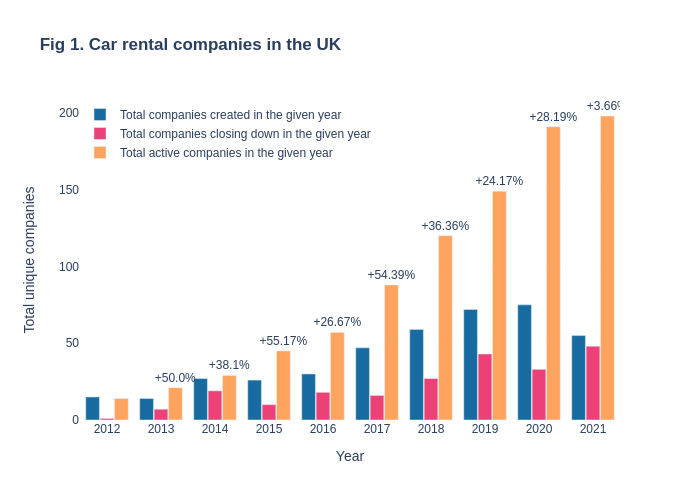

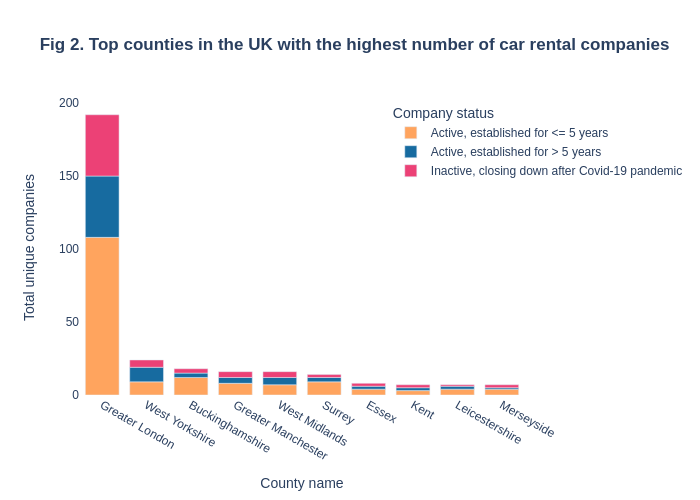

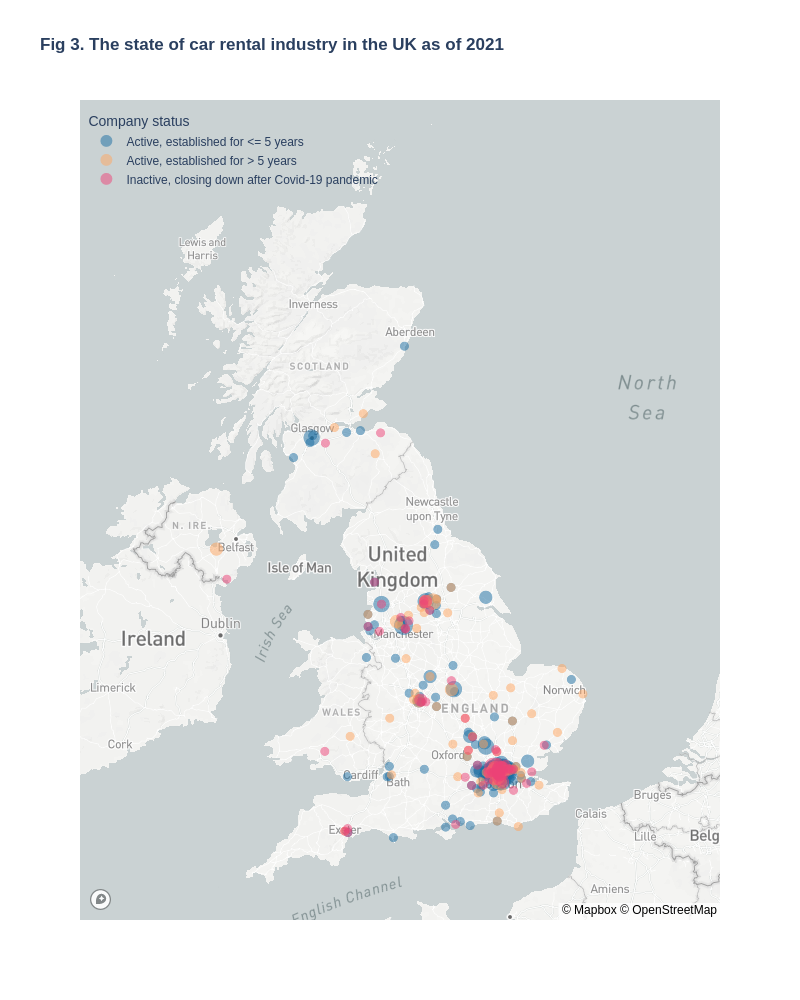

In [79]:
from IPython.display import display
car_fig_1 = Image(car_rental_by_year_fig.to_image(format="png"), width=700)
car_fig_2 = Image(car_rental_top_counties_fig.to_image(format="png"), width=700)
car_fig_3 = Image(car_rental_loc_fig.to_image(format="png")) 
display(car_fig_1, car_fig_2, car_fig_3)

**Is now a good time to start a new car rental company in the UK?**

Covid-19 pandemic has shown a significant impact on various sectors, including car rental businesses. Therefore, it is important for people who want to start a new car rental company to understand the current market. A sample of 539 car rental companies was obtained from the Companies House UK to analyze the market. **Fig 1.** illustrates that despite the constant growth in the number of active car rental companies over the past 10 years, it grew slowly in 2021, from **+28.19%** to only **+3.66%.** This is driven by the increasing number of companies closing down in 2021, which grew by **+45%**, and the declining number of new companies in 2021, growing negatively by **-26.67%**. These car rental companies are mostly located in Greater London (**Fig 2.**), implying that Greater London has more demands that the other regions. However, as denoted by red nodes in **Fig 3.**, a majority of car rental companies that has closed since the pandemic are also located in Greater London. Contrarily, smaller towns show a lower number of closed companies as we barely see red nodes outside the metropolitan area.  Some of these towns even have car rentals that have been operating for more than 5 years (Denoted by yellow nodes in Fig 3.). Starting a new business with a presence of long-established competitors might be more challenging. Therefore, it is best to aim for cities that provide lower chance of closing down and less well-established competitors, which are indicated by blue nodes, such as **Glasgow, Edinburgh, and Newcastle.** In conclusion, it is not a good time to start a new car rental company. However, opening in smaller cities might be a good opportunity.

# Business Question 2:
# "Which AI sector should the UK government invest in the next few years?"

### Business Question 2: Code:

## 2.1. Load data

### 2.1.A. Get artificial intelligence company list

In [ ]:
# Get artificial intelligence companies
ai_df = company_raw_df('artificial intelligence', company_count = 100, total_iteration = 10)

### 2.1.B. Get significant persons of the company

In [ ]:
# Get company person details
ai_company_person_df = get_company_persons(ai_df)

In [ ]:
# Extract the company number from `links.self` column
ai_company_person_df['company_number'] = ai_company_person_df['links.self'].astype('str').str[9:17]

# Select only useful columns from ai_company_person_df
ai_company_person_df = ai_company_person_df[['company_number','nationality','natures_of_control','country_of_residence','name','name_elements.title','date_of_birth.year']]

# Merge company person dataset into the original dataframe
ai_df = ai_df.merge(ai_company_person_df, how = 'left', left_on = 'company_number', right_on = 'company_number')

### 2.1.C. Get company detailed info

In [ ]:
# Get company details
ai_company_detail_df = get_company_details(ai_df)

In [ ]:
# Merge company details into the original dataframe
ai_df = ai_df.merge(ai_company_detail_df[['company_number','sic_codes']], how = 'left', left_on = 'company_number', right_on = 'company_number')

In [ ]:
#ai_df.to_csv('ai_df.csv')
#ai_df = pd.read_csv('~/CMSE114332021-2SS1SEM1/2021-week11-final-assignment-PG/ai_df.csv')

### 2.1.D. Parse date_of_creation and date_of_cessation to extract creation_year and cessation_year

In [ ]:
# Clean date format
ai_df = remove_incorrect_date_of_creation(ai_df)
ai_df = remove_incorrect_date_of_cessation(ai_df)

In [ ]:
# Add creation year into dataframe
ai_df['creation_year'] = get_creation_year(ai_df)

# Add cessation year into dataframe
ai_df['cessation_year'] = get_cessation_year(ai_df)

### 2.1.E. Get the first sic_codes of each company

Each company may have multiple sic_codes. Therefore, to simplify the analysis, we will only consider the first `sic_codes`, assuming that the first `sic_codes` would be the main industry type of each company

In [ ]:
ai_df = ai_df[(ai_df['sic_codes'].notnull()) & (ai_df['sic_codes']!='')]

In [ ]:
# Apply this only when your data is obtained via API
ai_df['sic_codes'] = ai_df['sic_codes'].str[0]

# Apply this only when you load the data from csv
#ai_df['sic_codes'] = ai_df['sic_codes'].apply(lambda x: x[1:-1].split(','))
#ai_df['sic_codes'] = ai_df['sic_codes'].str[0]
#ai_df['sic_codes'] = ai_df['sic_codes'].astype('str').str[1:6]

### 2.1.F. Get the company industry type by sic_codes

In [ ]:
sic_info_df = pd.read_csv('~/CMSE114332021-2SS1SEM1/2021-week11-final-assignment-PG/SIC07_CH_condensed_list_en.csv')
sic_info_df = sic_info_df.rename(columns={'Description':'industry_type'})
sic_info_df['SIC Code'] = sic_info_df['SIC Code'].astype(str)

In [ ]:
ai_df = ai_df.merge(sic_info_df, how='left', left_on='sic_codes', right_on='SIC Code')

## 2.2. Data cleaning

### 2.2.A. Check missing values

In [ ]:
# Check missing values in car rental dataframe
check_missing_values(ai_df, "Artificial intelligence company dataframe")

In [ ]:
# Remove unnecessary columns
ai_df = ai_df.drop(columns={'snippet','external_registration_number','country_of_residence','SIC Code'})

In [ ]:
# Remove rows with missing nationality, natures_of_control, country_of_residence, name_elements.title, date_of_birth.year
ai_df = ai_df[(ai_df['nationality'].notnull()) & 
              (ai_df['date_of_birth.year'].notnull()) &
              (ai_df['sic_codes'].notnull())
             ]

## 2.3. Analysis

### 2.3.A. Top industry type

In [ ]:
# Calculate the number of unique industry type
count_unique_industry = ai_df.agg({'industry_type':pd.Series.nunique})[0]
print(f'There are {count_unique_industry} unique industry types in the dataframe')

In [ ]:
# Since there are too many industry types in the dataframe,
# we are going to categorize them into 5 indusry types only based on the top industry types
top_ai_industry_df = ai_df.copy()
top_ai_industry_df = top_ai_industry_df.groupby('industry_type', as_index=False).agg({'company_number':pd.Series.nunique})
top_ai_industry_df = top_ai_industry_df.rename(columns={'company_number':'total_companies'})
top_ai_industry_df.sort_values('total_companies', ascending=False).head(5)

In [ ]:
# Create a function to group the industry type based on the top industry types
industry_type_group = []
for i, col in ai_df['industry_type'].items():
    if str(col) == 'Landscape service activities':
        industry_type_group.append('Landscape service')
    elif 'software development' in str(col).lower():
        industry_type_group.append('Software development')
    elif 'information technology' in str(col).lower():
        industry_type_group.append('Information technology')
    elif 'construction' in str(col).lower():
        industry_type_group.append('Construction')
    elif 'retail' in str(col).lower():
        industry_type_group.append('Retail')
    else:
        industry_type_group.append('Others')
        
ai_df['industry_type_group'] = industry_type_group

In [ ]:
# Create a dataframe for the visualization
ai_by_industry_group_df = ai_df.copy()
ai_by_industry_group_df = ai_by_industry_group_df.groupby('industry_type_group', as_index=False).agg({'company_number':pd.Series.nunique})
ai_by_industry_group_df = ai_by_industry_group_df.rename(columns={'company_number':'total_companies'})
ai_by_industry_group_df.sort_values('total_companies', ascending=False)

In [ ]:
# Visualize op industry types among artificial intelligence companies in the UK

# Step 1: Declare bar colors
colors = ['#AFAFB1',] * 6
colors[2] = '#176BA0' # Highlight the top industry

# Step 2: Declare data that we are using for x-axis, y-axis, and marker color
ai_by_industry_fig = go.Figure(go.Bar(x=ai_by_industry_group_df['industry_type_group'],
                                      y=ai_by_industry_group_df['total_companies'],
                                      marker_color=colors),
                               go.Layout(autosize=False, width=1000, height=600))

# Step 3: Customize the chart layout
ai_by_industry_fig.update_layout(
    title='<b> Fig 4. Top artificial intelligence companies by industry type <b>',
    xaxis_tickfont_size=12,
    xaxis=dict(
        title='Industry type',
        titlefont_size=14,
        tickfont_size=12
    ),
    yaxis=dict(
        title='Total unique companies',
        titlefont_size=14,
        tickfont_size=12
    ),
    legend=dict(
        orientation='v',
        x=0.7,
        y=1.0,
        bgcolor='rgba(255, 255, 255, 0)',
        bordercolor='rgba(255, 255, 255, 0)'
    ),
    barmode='relative',
    bargap=0.2,
    bargroupgap=0.05,
    plot_bgcolor='rgba(0, 0, 0, 0)',
    paper_bgcolor='rgba(0, 0, 0, 0)',
    uniformtext_minsize=8,
    uniformtext_mode='show',
    annotations=[dict(text='<b>A majority of AI companies in the UK operates<b>', x=1.2, y=140, font_size=12, showarrow=False),
                dict(text='<b>in landscape service industry<b>', x=1.6, y=130, font_size=12, showarrow=False)]
)

# Step 4: Show the chart
ai_by_industry_fig.show()

### 2.3.B. Relationship between company's age and company's leaders by industry type

In [ ]:
# Calculate company age 
ai_df = ai_df.copy()
ai_df['company_age'] = 2021 - ai_df['creation_year'].astype(int)
ai_df = ai_df.reset_index().drop(columns={'index'})

In [ ]:
# Calculate significant persons' age
ai_df = ai_df.copy()
ai_df['person_age'] = 2021 - ai_df['date_of_birth.year'].astype(int)
ai_df = ai_df.reset_index().drop(columns={'index'})

In [ ]:
# Calculate the number of active companies by company age, person age, and industry type
count_company_by_age_df = ai_df[ai_df['company_status']!='dissolved'].groupby(['company_age','person_age','industry_type_group'], as_index=False).agg({'company_number':pd.Series.nunique})

In [ ]:
# Visualize the number of car rental companies over the years
ai_company_by_age_fig = px.scatter(count_company_by_age_df, 
                                      x=count_company_by_age_df['company_age'],
                                      y=count_company_by_age_df['person_age'],
                                      size=count_company_by_age_df['company_number'],
                                      size_max=20,
                                      color=count_company_by_age_df['industry_type_group'],
                                      opacity=0.8,
                                      color_discrete_map={
                                        'Landscape service' : '#176BA0',
                                        'Software development' : '#B3C100',
                                        'Information technology' : '#EC4176',
                                        'Construction': '#9A77CF',
                                        'Retail':'#6AB187',
                                        'Others': '#FFA45E'},
                                      width=1000,
                                      height=600
                                     )

ai_company_by_age_fig.update_layout(
    title="<b> Fig 5. Relationship between company's age and company's management age<b>",
    xaxis_tickfont_size=12,
    xaxis=dict(
        title='Company age (Years)',
        titlefont_size=14,
        tickfont_size=12
    ),
    yaxis=dict(
        title='Person age (Years)',
        titlefont_size=14,
        tickfont_size=12
    ),
    legend=dict(
        orientation='v',
        x=1.0,
        y=1.0,
        title='Industry type',
        bgcolor='rgba(255, 255, 255, 0)',
        bordercolor='rgba(255, 255, 255, 0)'
    ),
    barmode='relative',
    bargap=0.2,
    bargroupgap=0.05,
    plot_bgcolor='rgba(0, 0, 0, 0)',
    paper_bgcolor='rgba(0, 0, 0, 0)',
    uniformtext_minsize=8,
    uniformtext_mode='show'
)

ai_company_by_age_fig.show()

### 2.3.B. Relationship between company leaders' nationality and industry type

In [ ]:
# Calculate the number of unique nationality of significant persons
count_unique_nationality = ai_df.agg({'nationality':pd.Series.nunique})[0]
print(f'There are {count_unique_nationality} unique nationalities in the dataframe')

In [ ]:
# Calculate top nationalities
top_nationality_df = ai_df.copy()
top_nationality_df = top_nationality_df.groupby('nationality', as_index=False).agg({'company_number':pd.Series.nunique})
top_nationality_df = top_nationality_df.rename(columns={'company_number':'total_companies'})
top_nationality_df.sort_values('total_companies', ascending=False).head(5)

In [ ]:
# From the previous table, we learned that in the dataframe, there is British, but also English, Scottish, and Welsh
# Therefore, before we proceed to the analysis, we are going to combine them into one single category: British
# and leave the other nationalities as is
nationality_group = []
for i, col in ai_df['nationality'].items():
    if str(col) == 'nan':
        nationality_group.append('Others')
    elif str(col) == 'British' or str(col) == 'English' or str(col) == 'Scottish' or str(col) == 'Welsh':
        nationality_group.append('British')
    elif str(col) == 'Italian' or str(col) == 'Indian' or str(col) == 'Romanian' or str(col) == 'Portuguese' or str(col) == 'Polish' or str(col) == 'German':
        nationality_group.append(col)
    else:
        nationality_group.append('Others')
        
ai_df['nationality_group'] = nationality_group

In [ ]:
# Calculate the number of companies by nationality and industry type
nationality_industry_df = ai_df.groupby(['nationality_group','industry_type_group'], as_index=False).agg({'company_number':pd.Series.nunique})
nationality_industry_df = nationality_industry_df.rename(columns={'company_number':'total_companies'})
nationality_industry_df.sort_values(['nationality_group','industry_type_group'])

In [ ]:
# Encode the categorical variables as to visualize the data in a Sankey diagram
nationality_industry_df['nationality_code'] = nationality_industry_df['nationality_group'].astype('category').cat.codes
nationality_industry_df['industry_type_code'] = nationality_industry_df['industry_type_group'].astype('category').cat.codes + 8

In [ ]:
# Show the data that we are going to use for Sankey diagram visualization
nationality_industry_df.sort_values(['nationality_group','industry_type_group'])

In [ ]:
# Assign colors for each category in the Sankey diagram
link_color = []
for i, col in nationality_industry_df['nationality_code'].items():
    if int(col) == 0:
        link_color.append('#FFF684') # Yellow
    if int(col) == 1:
        link_color.append('#D3DB6B') # Lime green
    if int(col) == 2:
        link_color.append('#FFA6C2') # Pink
    if int(col) == 3:
        link_color.append('#C7B0E8') # Light purple
    if int(col) == 4:
        link_color.append('#B6D7A8') # Light green
    if int(col) == 5:
        link_color.append('#FFC175') # Orange
    if int(col) == 6:
        link_color.append('#71DFE7') # Baby blue
    if int(col) == 7:
        link_color.append('#7CB3F7') # Cornflower blue
        
node_color = [
'#FFCC1D', '#B3C100', '#EC4176', '#9A77CF', '#6AB187', '#FFA45E', '#71DFE7', '#176BA0',
'#FFCC1D', '#B3C100', '#EC4176', '#9A77CF', '#6AB187', '#71DFE7']

In [ ]:
# Declare the parameters for the sankey diagra

label = nationality_industry_df['nationality_group'].unique().tolist() + nationality_industry_df['industry_type_group'].unique().tolist()
source = nationality_industry_df['nationality_code'].tolist()
target = nationality_industry_df['industry_type_code'].tolist()
value = nationality_industry_df['total_companies'].tolist()

link = dict(source = source, target = target, value = value, color = link_color)
node = dict(label = label, pad=200, thickness=20, color = node_color)
data = go.Sankey(link = link, node = node)
layout = go.Layout(autosize=False, width=1000, height=800)

# Create the sankey diagram
ai_sankey_fig = go.Figure(data=data, layout=layout)
ai_sankey_fig.update_layout(
    title="<b> Fig 6. Relationship between company leaders' nationality and company's industry type",
    plot_bgcolor='rgba(0, 0, 0, 0)',
    paper_bgcolor='rgba(0, 0, 0, 0)',
    uniformtext_minsize=10,
    uniformtext_mode='show'
)
ai_sankey_fig.show()

### Business Question 2: Mini-report and visualisation:

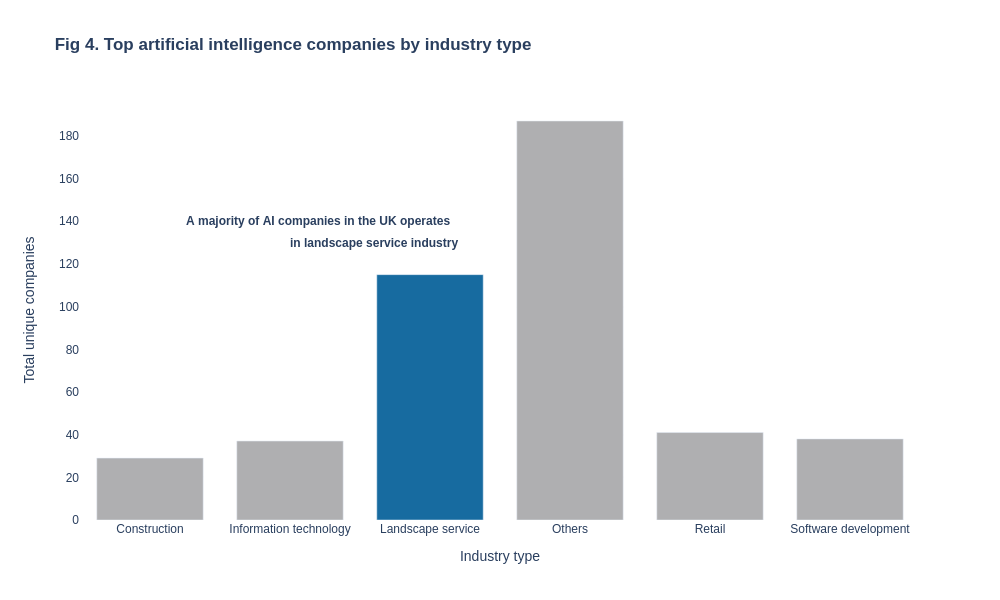

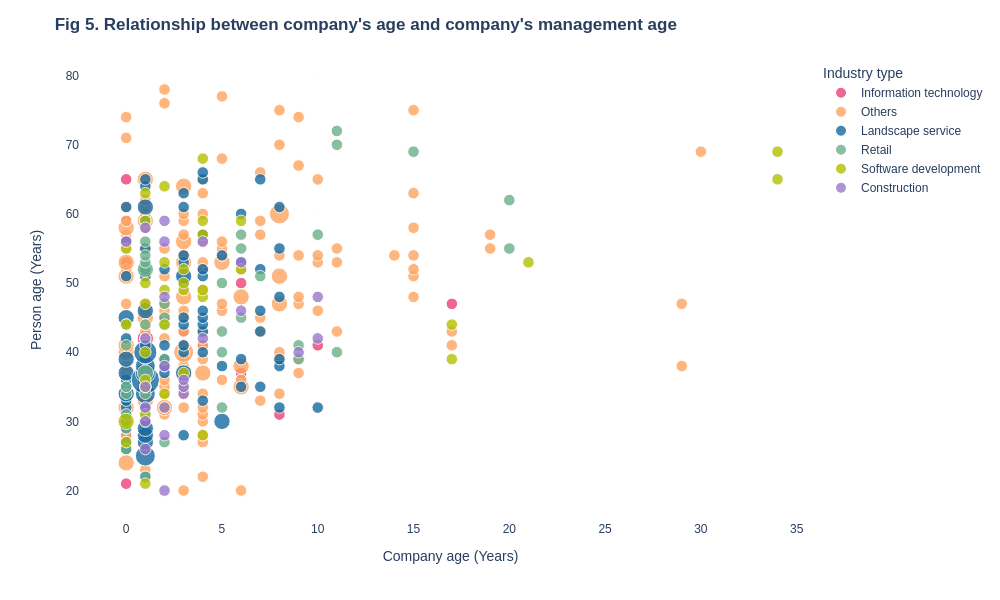

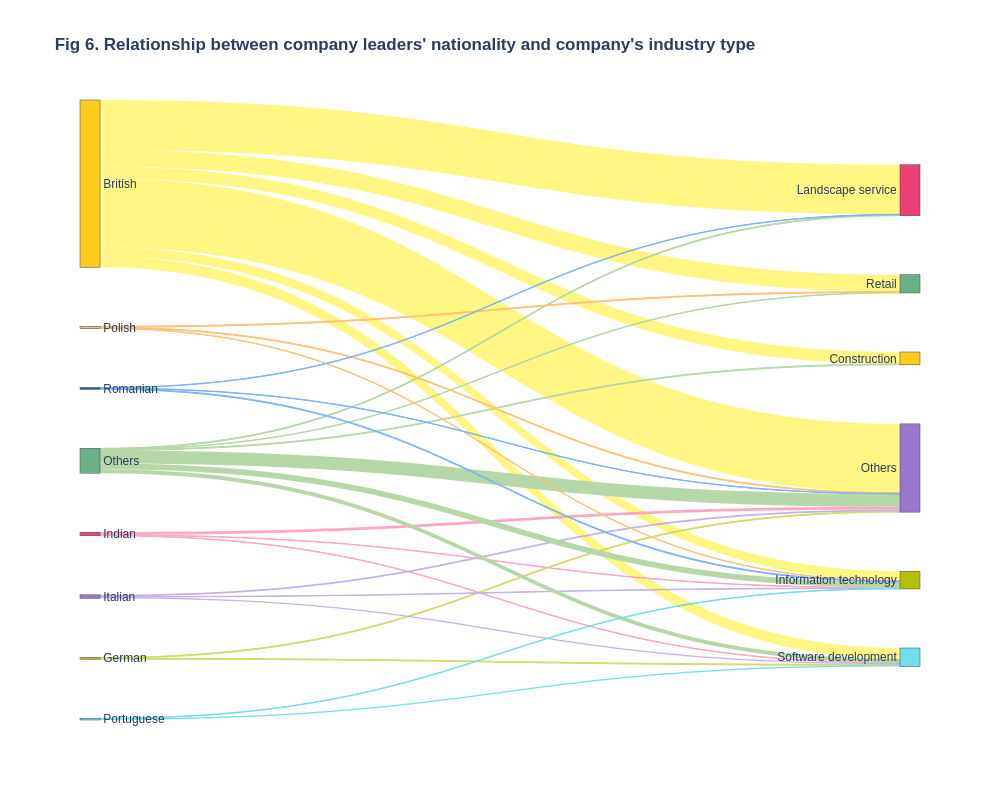

In [80]:
from IPython.display import display
import cv2

ai_fig_1 = Image(ai_by_industry_fig.to_image(format="png"))
ai_fig_2 = Image(ai_company_by_age_fig.to_image(format="png"))
ai_fig_3 = Image(ai_sankey_fig.to_image(format="png")) 
display(ai_fig_1, ai_fig_2, ai_fig_3)

**"Which AI sector should the UK government invest in the next few years?"**

Recently, the UK government released a statement on "Ten-year plan to make Britain a global AI superpower," emphasizing the national strategy to build an AI-enabled ecosystem. However, AI is a broad field that can be implemented in various sectors, so it is important for the UK government to understand the market as to invest in the right industries. **Fig 4.** showed that there are **83** unique AI sectors operating in the UK right now with **Landscape Service** being the most popular sector. Meanwhile, **Fig 5.** described that most of these companies only started **less than 5 years ago** and a majority of the leaders are ranging from **30 - 40 years old.** However, companies that have operated for **>= 15 years** are led by more mature leaders (**>= 40 years old**). Meanwhile, **Fig 6.** illustrates the relationship between company leaders' nationality and industry type. Despite operating in the UK, only 80% of these companies are led by British. 20% of them are led by foreigners, including Italian, Indian, German, Polish, Romanian, and Portuguese. Software development, which is the oldest AI sector in the UK, seems to be the most inclusive in terms of company leaders' nationality. In conclusion, the UK government should focus on **software development** and **AI-based landscape services** and invest in more mature leaders to ensure the company's sustainability.

# Business Question 3:
# "Which is the most sustainable business: Hotel, hostel, or bed and breakfast?"

### Business Question 3: Code:

### 3.1.A. Get hotel, hostel, and bed and breakfast company list

In [81]:
# Get company list
hotel_df = company_raw_df('hotel', company_count = 100, total_iteration = 10)
hostel_df = company_raw_df('hostel', company_count = 100, total_iteration = 10)
backpackers_df = company_raw_df('backpacker', company_count = 100, total_iteration = 10)
bnb_df = company_raw_df('bed breakfast', company_count = 100, total_iteration = 10)

Initiating API request for hotel companies...
API request for hotel companies is finished. Successfully obtained 1000 records from 10 iterations. 

Initiating API request for hostel companies...
API request for hostel companies is finished. Successfully obtained 417 records from 10 iterations. 

Initiating API request for backpacker companies...
API request for backpacker companies is finished. Successfully obtained 152 records from 10 iterations. 

Initiating API request for bed breakfast companies...
API request for bed breakfast companies is finished. Successfully obtained 1000 records from 10 iterations. 



### 3.1.B. Get company detailed info

In [82]:
%%time

# Get company details
hotel_company_detail_df = get_company_details(hotel_df)
hostel_company_detail_df = get_company_details(hostel_df)
backpacker_company_detail_df = get_company_details(backpackers_df)
bnb_company_detail_df = get_company_details(bnb_df)

Initiating iteration number 1...
Successfully obtained 500 records of company details
Initiating iteration number 2...
Successfully obtained 1000 records of company details
API request is finished
Initiating iteration number 1...
Successfully obtained 417 records of company details
API request is finished
Initiating iteration number 1...
Successfully obtained 152 records of company details
API request is finished
Initiating iteration number 1...
Successfully obtained 500 records of company details
Initiating iteration number 2...
Successfully obtained 1000 records of company details
API request is finished
CPU times: user 1min, sys: 3.14 s, total: 1min 3s
Wall time: 20min 24s


In [83]:
# Merge company details into the original dataframe
hotel_df = hotel_df.merge(hotel_company_detail_df[['company_number','sic_codes']], how = 'left', left_on = 'company_number', right_on = 'company_number')
hostel_df = hostel_df.merge(hostel_company_detail_df[['company_number','sic_codes']], how = 'left', left_on = 'company_number', right_on = 'company_number')
backpackers_df = backpackers_df.merge(backpacker_company_detail_df[['company_number','sic_codes']], how = 'left', left_on = 'company_number', right_on = 'company_number')
bnb_df = bnb_df.merge(bnb_company_detail_df[['company_number','sic_codes']], how = 'left', left_on = 'company_number', right_on = 'company_number')

In [84]:
# Declare the category for each dataset, so we can distinguish them in the combined dataset
hotel_df['category'] = 'Hotel'
hostel_df['category'] = 'Hostel' # Combine hostel_df and backpackers_df into a single dataframe
backpackers_df['category'] = 'Hostel' # Combine hostel_df and backpackers_df into a single dataframe
bnb_df['category'] = 'B&B'

In [85]:
# Combine hostel_df and backpackers_df into a single dataframe
all_hotel_df = pd.concat([hotel_df, hostel_df, backpackers_df, bnb_df])
all_hotel_df = all_hotel_df.reset_index().drop(columns={'index'})

### 3.1.C. Parse date_of_creation and date_of_cessation to extract creation_year and cessation_year

In [86]:
# Clean date format
all_hotel_df = remove_incorrect_date_of_creation(all_hotel_df)
all_hotel_df = remove_incorrect_date_of_cessation(all_hotel_df)

In [87]:
# Add creation year into dataframe
all_hotel_df['creation_year'] = get_creation_year(all_hotel_df)

# Add cessation year into dataframe
all_hotel_df['cessation_year'] = get_cessation_year(all_hotel_df)

### 3.1.D. Parse address to get the city

In [88]:
# Parse the address
all_hotel_df = all_hotel_df[all_hotel_df['address'].notnull()]
all_hotel_df = parse_address(all_hotel_df)

## 3.2. Data cleaning

### 3.2.A. Handling missing values

In [ ]:
# Check missing values in car rental dataframe
check_missing_values(all_hotel_df, "Hotel dataframe")

In [89]:
# Remove unnecessary columns
all_hotel_df = all_hotel_df.drop(columns={'address_snippet','kind','matches','external_registration_number','country','premises','address_line_1','locality','address_line_2','region','po_box','care_of_name'})

In [90]:
# Remove rows with missing sic_codes and company_status
all_hotel_df = all_hotel_df[(all_hotel_df['sic_codes'].notnull()) & (all_hotel_df['company_status'].notnull())]

### 3.2.B. Get the first sic_codes of each company

Each company may have multiple sic_codes. Therefore, to simplify the analysis, we will only consider the first `sic_codes`, assuming that the first `sic_codes` would be the main industry type of each company

In [91]:
# Remove rows with missing `sic_codes`
all_hotel_df = all_hotel_df[(all_hotel_df['sic_codes'].notnull()) & (all_hotel_df['sic_codes']!='')]

In [92]:
# Apply this only when your data is obtained via API
all_hotel_df['sic_codes'] = all_hotel_df['sic_codes'].str[0]

### 3.2.C. Filter companies by SIC code

In [93]:
# Create a function to filter companies by SIC code
def filter_company_by_sic_code(df, sic_code_list):
    result_df = df[df['sic_codes'].isin(sic_code_list)]
    return result_df

In [94]:
# Declare the SIC code list
sic_code_list = ['55100','55201','55202','55209','55900']

# Filter the dataframe by SIC code
all_hotel_df = filter_company_by_sic_code(all_hotel_df, sic_code_list)

### 3.2.D. Get location info

In [95]:
%%time
all_hotel_df = get_coordinates(all_hotel_df)

CPU times: user 3min 4s, sys: 16.7 s, total: 3min 21s
Wall time: 3min 23s


# 3.3. Analysis

### 3.3.A. Calculate company's age

In [96]:
# Calculate the company age
company_age = []
for i, col in all_hotel_df['company_status'].items():
    if str(col) == 'active':
        company_age.append(2021 - int(all_hotel_df['creation_year'][i]))
    elif str(col) == 'dissolved' and str(all_hotel_df['cessation_year'][i]) != 'nan':
        company_age.append(int(all_hotel_df['cessation_year'][i]) - int(all_hotel_df['creation_year'][i]))
    elif str(col) == 'dissolved' and str(all_hotel_df['cessation_year'][i]) == 'nan':
        company_age.append(2021 - int(all_hotel_df['creation_year'][i]))
    elif str(col) == 'nan':
        company_age.append(2021 - int(all_hotel_df['creation_year'][i]))        
    else:
        company_age.append(np.nan)

all_hotel_df['company_age'] = company_age
all_hotel_df = all_hotel_df.reset_index().drop(columns={'index'})

### 3.3.B. Percentage of companies by company status

In [97]:
# Calculate unique companies by company status
company_status_df = all_hotel_df[all_hotel_df['company_status'].isin(['active','dissolved'])]
company_status_df = company_status_df.groupby(['company_status','category'], as_index=False).agg({'company_number':pd.Series.nunique})
company_status_df = company_status_df.rename(columns={'company_number':'total_companies'})

In [99]:
company_status_df['company_status'] = company_status_df['company_status'].replace('active','Active')
company_status_df['company_status'] = company_status_df['company_status'].replace('dissolved','Dissolved')

In [100]:
# Visualize hotel companies by accommodation type and company status
hotel_status_fig = make_subplots(rows=1, cols=3,
                    specs=[[{'type':'domain'},
                            {'type':'domain'},
                            {'type':'domain'}]])
hotel_status_fig.add_trace(go.Pie(labels=company_status_df[company_status_df['category']=='Hotel']['company_status'],
                     values=company_status_df[company_status_df['category']=='Hotel']['total_companies'],
                     name="Hotel",
                     marker_colors=['#F9A602', '#AF4BCE']), 1, 1)
hotel_status_fig.add_trace(go.Pie(labels=company_status_df[company_status_df['category']=='Hostel']['company_status'],
                     values=company_status_df[company_status_df['category']=='Hostel']['total_companies'],
                     name="Hostel",
                     marker_colors=['#F9A602', '#AF4BCE']), 1, 2)
hotel_status_fig.add_trace(go.Pie(labels=company_status_df[company_status_df['category']=='B&B']['company_status'],
                     values=company_status_df[company_status_df['category']=='B&B']['total_companies'],
                     name="B&B",
                     marker_colors=['#F9A602', '#AF4BCE']), 1, 3)

hotel_status_fig.update_traces(hole=0.5, hoverinfo="label+percent+name")

hotel_status_fig.update_layout(
    title="<b> Fig 7. Percentage of active and dissolved companies by accommodation type<b>",
    legend=dict(
        orientation='h',
        x=0.3,
        y=1.1,
        title='Company status',
        bgcolor='rgba(255, 255, 255, 0)',
        bordercolor='rgba(255, 255, 255, 0)'
    ),
    annotations=[dict(text='<b>Hotel<b>', x=0.13, y=0.05, font_size=12, showarrow=False),
                 dict(text='<b>Hostel<b>', x=0.5, y=0.05, font_size=12, showarrow=False),
                 dict(text='<b>B&B<b>', x=0.885, y=0.05, font_size=12, showarrow=False)],
    plot_bgcolor='rgba(0, 0, 0, 0)',
    paper_bgcolor='rgba(0, 0, 0, 0)',
    uniformtext_minsize=8,
    uniformtext_mode='show'
)

hotel_status_fig.show()

### 3.3.C. Calculate the distribution of company's age by accommodation type and company status

In [101]:
# Visualize the distribution of company's age by accommodation type and company status
hotel_age_fig = go.Figure()
hotel_age_fig.add_trace(go.Box(x=all_hotel_df[all_hotel_df['company_status']=='dissolved']['category'],
                          y=all_hotel_df[all_hotel_df['company_status']=='dissolved']['company_age'],
                          name='Dissolved',
                          marker_color = '#AF4BCE',
                          boxpoints='all',
                          jitter=0.2,
                          whiskerwidth=0.5,
                          marker_size=3,
                          line_width=2)
                       )
hotel_age_fig.add_trace(go.Box(x=all_hotel_df[all_hotel_df['company_status']=='active']['category'],
                          y=all_hotel_df[all_hotel_df['company_status']=='active']['company_age'],
                          name='Active',
                          marker_color = '#EE9A3A',
                          boxpoints='all',
                          jitter=0.2,
                          whiskerwidth=0.5,
                          marker_size=3,
                          line_width=2)
                       )

hotel_age_fig.update_layout(
    title="<b> Fig 8. Distribution of company lifespan by accommodation type and company status<b>",
    xaxis_tickfont_size=12,
    xaxis=dict(
        title='Accommodation type',
        titlefont_size=14,
        tickfont_size=12
    ),
    yaxis=dict(
        title='Company lifespan (Years)',
        titlefont_size=14,
        tickfont_size=12
    ),
    legend=dict(
        orientation='h',
        x=0.3,
        y=1.1,
        title='Company status',
        bgcolor='rgba(255, 255, 255, 0)',
        bordercolor='rgba(255, 255, 255, 0)'
    ),
    boxmode='group',
    plot_bgcolor='rgba(0, 0, 0, 0)',
    paper_bgcolor='rgba(0, 0, 0, 0)',
    uniformtext_minsize=8,
    uniformtext_mode='show'
)

hotel_age_fig.show()

### 3.3.D. Get top counties based on the number of hotels

In [102]:
county_group_df = all_hotel_df[all_hotel_df['company_status'].isin(['active','dissolved'])]
county_group_df = county_group_df.groupby(['county_name','category'], as_index=False).agg({'company_number':pd.Series.nunique})
county_group_df = county_group_df.rename(columns={'company_number':'total_companies'})

In [103]:
county_group = []
for i, col in all_hotel_df['county_name'].items():
    if str(col) == 'Greater London' or str(col) == 'City of Edinburgh' or str(col) == 'West Midlands' or str(col) == 'Greater Manchester':
        county_group.append('Big city')
    else:
        county_group.append('Small town')
        
all_hotel_df['county_group'] = county_group

In [104]:
# Visualize the distribution of company's age by accommodation type and location
hotel_county_fig = go.Figure()
hotel_county_fig.add_trace(go.Box(x=all_hotel_df[all_hotel_df['county_group']=='Big city']['category'],
                          y=all_hotel_df[all_hotel_df['county_group']=='Big city']['company_age'],
                          name='Big city',
                          marker_color = '#AF4BCE',
                          boxpoints='all',
                          jitter=0.2,
                          whiskerwidth=0.5,
                          marker_size=3,
                          line_width=2)
                       )
hotel_county_fig.add_trace(go.Box(x=all_hotel_df[all_hotel_df['county_group']=='Small town']['category'],
                          y=all_hotel_df[all_hotel_df['county_group']=='Small town']['company_age'],
                          name='Small town',
                          marker_color = '#EE9A3A',
                          boxpoints='all',
                          jitter=0.2,
                          whiskerwidth=0.5,
                          marker_size=3,
                          line_width=2)
                       )

hotel_county_fig.update_layout(
    title="<b> Fig 9. Distribution of company lifespan by accommodation type and location<b>",
    xaxis_tickfont_size=12,
    xaxis=dict(
        title='Accommodation type',
        titlefont_size=14,
        tickfont_size=12
    ),
    yaxis=dict(
        title='Company lifespan (Years)',
        titlefont_size=14,
        tickfont_size=12
    ),
    legend=dict(
        orientation='h',
        x=0.3,
        y=1.1,
        title='Accommodation location',
        bgcolor='rgba(255, 255, 255, 0)',
        bordercolor='rgba(255, 255, 255, 0)'
    ),
    boxmode='group',
    plot_bgcolor='rgba(0, 0, 0, 0)',
    paper_bgcolor='rgba(0, 0, 0, 0)',
    uniformtext_minsize=8,
    uniformtext_mode='show'
)

hotel_county_fig.show()

### Business Question 3: Mini-report and visualisation:

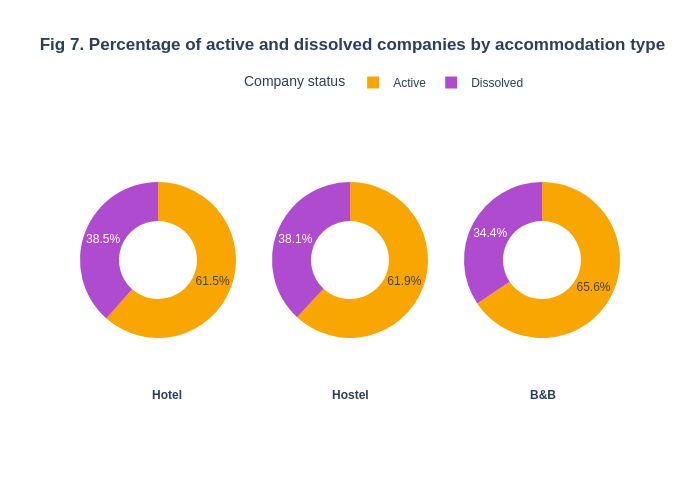

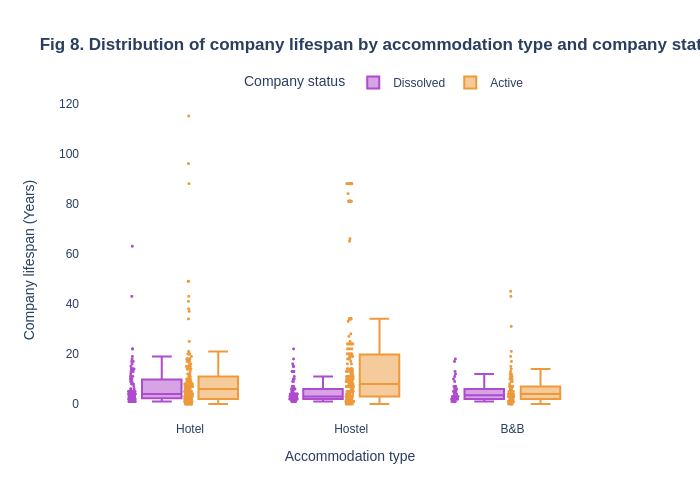

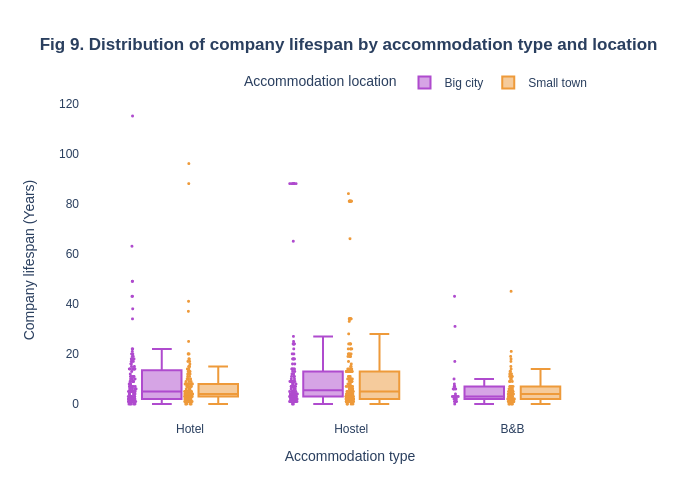

In [105]:
hotel_fig_1 = Image(hotel_status_fig.to_image(format="png"), width=800)
hotel_fig_2 = Image(hotel_age_fig.to_image(format="png"), width=800)
hotel_fig_3 = Image(hotel_county_fig.to_image(format="png"), width=800)
display(hotel_fig_1, hotel_fig_2, hotel_fig_3)

**"Which is the most sustainable business: Hotel, hostel, or bed and breakfast?"**

Starting a hospitality business might be challenging when it comes to choosing between building a hotel, hostel, or bed & breakfast. Hostel is usually cheaper and preferred by budget travellers, while bed & breakfast is usually suitable for group or family travellers. This study aims at understanding which type of accommodation setting is the most sustainable for a business as to help aspiring business owners starting their business. **Fig 7.** showed that the three categories have similar percentage of dissolved companies, with B&B being the lowest at **34.4%**. However, as seen in **Fig 8.**, we learned that **75%** of active B&B companies are only operating for **7 years**, which is lower than that of **hotel (11 years)** and **hostel (19.75 years).** This indicates that the B&B business model is rather new compared to the others. Meanwhile, **Fig 9.** compared the distribution of company lifespan between big cities and small towns. From this figure, we learned that hotels located in big cities tend to survive longer than that of small towns. Contrarily, for hostels and B&B, there was no significant difference between company lifespan in big cities and small towns. Overall, we can conclude that hostel is the most sustainable business with higher lifespan in both big cities and small towns.